In this notebook, we show step-by-step how to perform text classification by fine-tuning a BERT-based model.

Here we install the [transformers]( https://github.com/huggingface/transformers) package, from [Hugging Face]( https://huggingface.co/).
We use one of its pre-trained BERT models, more specifically a compact model that is trained through model distillation. We will use the package to:
- Tokenize the text according to the BERT model specification, using its [DistilBertTokenizer]( https://huggingface.co/transformers/model_doc/distilbert.html) class
- Instantiate a pre-trained BERT model, modified for the text classification task, using its [DistilBertForSequenceClassification](https://huggingface.co/transformers/model_doc/distilbert.html) class, that we will then fine-tuning for our specific dataset.

For a comprehensive tutorial about using this package to fine-tune BERT for text classification, please see [here]( https://mccormickml.com/2019/07/22/BERT-fine-tuning/).

Please notice that this notebook was create in a hosted Jupyter environment on Azure ML. This environment already has all other packages we need here such as NumPy, Pandas, Scikit-Learn, and PyTorch. For details about this hosted environment, please see [here]( https://docs.microsoft.com/en-us/azure/machine-learning/tutorial-1st-experiment-sdk-setup).

In [1]:
!pip install transformers

We then load and inspect the dataset we had previously prepared. In order to train faster, we use the sampled version, which contains 10% of the original prepared dataset.

In [2]:
import pandas as pd

df = pd.read_csv('./data/consumer_complaint_data_sample_prepared.csv')

In [3]:
df.shape

(47193, 3)

In [4]:
df.head(10)

,Product,Complaint,Product_Label
0,Mortgage,after falling behind on my mortgage due to cos...,5
1,Credit Reporting,in 2016 my husband and i had a family circumst...,2
2,Loans,i purchased the from in washington in the sale...,4
3,Credit Reporting,public records suppressed from reporting as pu...,2
4,Debt Collection,i received a phone call on my work phone on at...,3
5,Credit Reporting,i have been applying for work for 30 days i ha...,2
6,Credit Reporting,contacted equifax and on 2017 regarding an col...,2
7,Card Services,the credit card company for home depot citi re...,1
8,Debt Collection,this company which i hold no contract with nor...,3
9,Card Services,as of i had a credit card balance of 810 00 i ...,1


In [5]:
label_counts = pd.DataFrame(df['Product'].value_counts())
label_counts

,Product
Credit Reporting,16755
Debt Collection,10388
Mortgage,5961
Loans,4980
Card Services,4930
Banking Services,4179


Here we create an array with the label names in the order they were numerically encoded. We use them later when plotting model performance data.

In [6]:
label_values = list(label_counts.index)
order = list(pd.DataFrame(df['Product_Label'].value_counts()).index)
label_values = [l for _,l in sorted(zip(order, label_values))]

label_values

['Banking Services',
 'Card Services',
 'Credit Reporting',
 'Debt Collection',
 'Loans',
 'Mortgage']

We need to create 2 arrays: one with the textual data, which is our feature data, and one with the numerically encoded labels, representing our target data.

In [7]:
texts = df['Complaint'].values
labels = df['Product_Label'].values

BERT is a ‘heavy-weight’´model. This makes the training a very resource-intensive process, specially when we are fine-tuning for all model layers. To mitigate this, we can control the sequence length of our input text, which is given by the number of tokens in our input text, plus 2 special tokens to mark the beginning and ending of a text sequence.

From a total of about 47K sentences, we notice that we have about 7.8K sentences with sequence length equals or greater than 300.

In [8]:
text_lengths = [len(texts[i].split()) for i in range(len(texts))]
print(min(text_lengths))
print(max(text_lengths))

5
5485


In [9]:
sum([1 for i in range(len(text_lengths)) if text_lengths[i] >= 300])

7849

Here we instantiate a BERT tokenizer and show an example of a tokenized text. 

In [10]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

print('Original Text: ', texts[0], '\n')
print('Tokenized Text: ', tokenizer.tokenize(texts[0]), '\n')
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(texts[0])))

Original Text:  after falling behind on my mortgage due to costs from a federally declared disaster affecting my home and divorce i have been working with my loan servicer wells fargo to try an obtain an affordable loan modification and avoid foreclosure wells fargo has not been easy to work with has not followed guidelines set by in processing the modification request and has not tried in good faith to work with me specifically 1 after tremendous amounts of follow up and documentation being submitted wells fargo finally replied with a loan modification offer on however the payment amount was over 440 00 higher than my current loan payments and used a valuation of which is much higher than the property is worth 
2 i appealed their decision on on the basis that my p i payment was higher than prior and the higher valuation used i also submitted my valuation of with supporting documentation recent appraisal as well as a appraisal in line with the valuation 
3 on we had a nj state foreclos

We then tokenize and encode the entire dataset. In this process, we perform the following:
- tokenize the text as shown above
- encode it to the corresponding numeric values for each token.
- truncate it to the maximum sequence length of 300.
- pad the tokens positions greater than 300.
- include the special token IDs to mark the beginning and end of each sequence.

In [11]:
text_ids = [tokenizer.encode(text, max_length=300, pad_to_max_length=True) for text in texts]

text_ids[0]

[101,
 2044,
 4634,
 2369,
 2006,
 2026,
 14344,
 2349,
 2000,
 5366,
 2013,
 1037,
 20892,
 4161,
 7071,
 12473,
 2026,
 2188,
 1998,
 8179,
 1045,
 2031,
 2042,
 2551,
 2007,
 2026,
 5414,
 2326,
 2099,
 7051,
 23054,
 2000,
 3046,
 2019,
 6855,
 2019,
 15184,
 5414,
 14080,
 1998,
 4468,
 18921,
 20464,
 2891,
 5397,
 7051,
 23054,
 2038,
 2025,
 2042,
 3733,
 2000,
 2147,
 2007,
 2038,
 2025,
 2628,
 11594,
 2275,
 2011,
 1999,
 6364,
 1996,
 14080,
 5227,
 1998,
 2038,
 2025,
 2699,
 1999,
 2204,
 4752,
 2000,
 2147,
 2007,
 2033,
 4919,
 1015,
 2044,
 14388,
 8310,
 1997,
 3582,
 2039,
 1998,
 12653,
 2108,
 7864,
 7051,
 23054,
 2633,
 3880,
 2007,
 1037,
 5414,
 14080,
 3749,
 2006,
 2174,
 1996,
 7909,
 3815,
 2001,
 2058,
 17422,
 4002,
 3020,
 2084,
 2026,
 2783,
 5414,
 10504,
 1998,
 2109,
 1037,
 26004,
 1997,
 2029,
 2003,
 2172,
 3020,
 2084,
 1996,
 3200,
 2003,
 4276,
 1016,
 1045,
 12068,
 2037,
 3247,
 2006,
 2006,
 1996,
 3978,
 2008,
 2026,
 1052,
 1045,
 7909,
 2

In [12]:
text_ids_lengths = [len(text_ids[i]) for i in range(len(text_ids))]
print(min(text_ids_lengths))
print(max(text_ids_lengths))

300
300


To fine-tune our model, we need two inputs: one array of token IDs (created above) and one array of a corresponding binary mask, called attention mask in the BERT model specification. Each attention mask has the same length of the corresponding input sequence and has a 0 if the corresponding token is a pad token, or a 1 otherwise. 

In [13]:
att_masks = []
for ids in text_ids:
    masks = [int(id > 0) for id in ids]
    att_masks.append(masks)
    
att_masks[0]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


Here we split the input and output arrays created before into train, validation, and test sets. We use 80% of the data for training, 10% for training validation, and 10% for final testing.

In [14]:
from sklearn.model_selection import train_test_split

train_x, test_val_x, train_y, test_val_y = train_test_split(text_ids, labels, random_state=111, test_size=0.2)
train_m, test_val_m = train_test_split(att_masks, random_state=111, test_size=0.2)

test_x, val_x, test_y, val_y = train_test_split(test_val_x, test_val_y, random_state=111, test_size=0.5)
test_m, val_m = train_test_split(test_val_m, random_state=111, test_size=0.5)

We are working with the PyTorch artifacts in the transformers library, therefore we need our model input and output data as PyTorch tensors.

In [15]:
import torch

train_x = torch.tensor(train_x)
test_x = torch.tensor(test_x)
val_x = torch.tensor(val_x)
train_y = torch.tensor(train_y)
test_y = torch.tensor(test_y)
val_y = torch.tensor(val_y)
train_m = torch.tensor(train_m)
test_m = torch.tensor(test_m)
val_m = torch.tensor(val_m)

print(train_x.shape)
print(test_x.shape)
print(val_x.shape)
print(train_y.shape)
print(test_y.shape)
print(val_y.shape)
print(train_m.shape)
print(test_m.shape)
print(val_m.shape)

torch.Size([37754, 300])
torch.Size([4719, 300])
torch.Size([4720, 300])
torch.Size([37754])
torch.Size([4719])
torch.Size([4720])
torch.Size([37754, 300])
torch.Size([4719, 300])
torch.Size([4720, 300])


To feed data into the model for training, we use Pytorch’s Dataset, DataLoader, and Sampler. For feeding training data, which drives model weights updates, we use the RandomSampler. For feeding the validation data we can use the SequentialSampler.

In [16]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_x, train_m, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_x, val_m, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

Here we instantiate our model class. We use a compact version, that is trained through model distillation from a base BERT model and modified to include a classification layer at the output. This compact version has 6 transformer layers instead of 12 as in the original BERT model. Please see [here]( https://github.com/huggingface/transformers/tree/master/examples/distillation) for more details.

In [17]:
from transformers import DistilBertForSequenceClassification, AdamW, DistilBertConfig

num_labels = len(set(labels))

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels,
                                                            output_attentions=False, output_hidden_states=False)

BERT is a very large model. Unless you are freezing model weights in all layers but the classification layer, it is recommended to train it on a GPU.

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = model.to(device)

cuda


Here we print the model architecture and all model learnable parameters.

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of trainable parameters:', count_parameters(model), '\n', model)

Number of trainable parameters: 66958086 
 DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (dropout): Dropout(p=0.1, inplace=False)
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_a

In [20]:
[n for n, p in model.named_parameters()]

['distilbert.embeddings.word_embeddings.weight',
 'distilbert.embeddings.position_embeddings.weight',
 'distilbert.embeddings.LayerNorm.weight',
 'distilbert.embeddings.LayerNorm.bias',
 'distilbert.transformer.layer.0.attention.q_lin.weight',
 'distilbert.transformer.layer.0.attention.q_lin.bias',
 'distilbert.transformer.layer.0.attention.k_lin.weight',
 'distilbert.transformer.layer.0.attention.k_lin.bias',
 'distilbert.transformer.layer.0.attention.v_lin.weight',
 'distilbert.transformer.layer.0.attention.v_lin.bias',
 'distilbert.transformer.layer.0.attention.out_lin.weight',
 'distilbert.transformer.layer.0.attention.out_lin.bias',
 'distilbert.transformer.layer.0.sa_layer_norm.weight',
 'distilbert.transformer.layer.0.sa_layer_norm.bias',
 'distilbert.transformer.layer.0.ffn.lin1.weight',
 'distilbert.transformer.layer.0.ffn.lin1.bias',
 'distilbert.transformer.layer.0.ffn.lin2.weight',
 'distilbert.transformer.layer.0.ffn.lin2.bias',
 'distilbert.transformer.layer.0.output_laye

In the following 5 cells we define our PyTorch optimizer and corresponding parameters, learning rate scheduler, and the training loop for the fine-tuning procedure. We train for 4 epochs.

In [21]:
learning_rate = 1e-5
adam_epsilon = 1e-8

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.2},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [22]:
from transformers import get_linear_schedule_with_warmup

num_epochs = 4
total_steps = len(train_dataloader) * num_epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [23]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [24]:
import numpy as np
import random

seed_val = 111

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [25]:
train_losses = []
val_losses = []
num_mb_train = len(train_dataloader)
num_mb_val = len(val_dataloader)

if num_mb_val == 0:
    num_mb_val = 1

for n in range(num_epochs):
    train_loss = 0
    val_loss = 0
    start_time = time.time()
    
    for k, (mb_x, mb_m, mb_y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        model.train()
        
        mb_x = mb_x.to(device)
        mb_m = mb_m.to(device)
        mb_y = mb_y.to(device)
        
        outputs = model(mb_x, attention_mask=mb_m, labels=mb_y)
        
        loss = outputs[0]
        #loss = model_loss(outputs[1], mb_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.data / num_mb_train
    
    print ("\nTrain loss after itaration %i: %f" % (n+1, train_loss))
    train_losses.append(train_loss.cpu())
    
    with torch.no_grad():
        model.eval()
        
        for k, (mb_x, mb_m, mb_y) in enumerate(val_dataloader):
            mb_x = mb_x.to(device)
            mb_m = mb_m.to(device)
            mb_y = mb_y.to(device)
        
            outputs = model(mb_x, attention_mask=mb_m, labels=mb_y)
            
            loss = outputs[0]
            #loss = model_loss(outputs[1], mb_y)
            
            val_loss += loss.data / num_mb_val
            
        print ("Validation loss after itaration %i: %f" % (n+1, val_loss))
        val_losses.append(val_loss.cpu())
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Time: {epoch_mins}m {epoch_secs}s')


Train loss after itaration 1: 0.710054
Validation loss after itaration 1: 0.508176
Time: 10m 44s

Train loss after itaration 2: 0.449463
Validation loss after itaration 2: 0.467151
Time: 10m 45s

Train loss after itaration 3: 0.389150
Validation loss after itaration 3: 0.461241
Time: 10m 43s

Train loss after itaration 4: 0.351935
Validation loss after itaration 4: 0.457820
Time: 10m 44s


After training, we can save the model and necessary configuration parameters, to recreate it later and use it to score the test data. Here we also save the losses computed from both training and validation data.

In [26]:
import pickle
import os

out_dir = './model'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(out_dir)
tokenizer.save_pretrained(out_dir)

with open(out_dir + '/train_losses.pkl', 'wb') as f:
    pickle.dump(train_losses, f)
    
with open(out_dir + '/val_losses.pkl', 'wb') as f:
    pickle.dump(val_losses, f)

In [27]:
out_dir = './model'

model = DistilBertForSequenceClassification.from_pretrained(out_dir)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

with open(out_dir + '/train_losses.pkl', 'rb') as f:
    train_losses = pickle.load(f)
    
with open(out_dir + '/val_losses.pkl', 'rb') as f:
    val_losses = pickle.load(f)

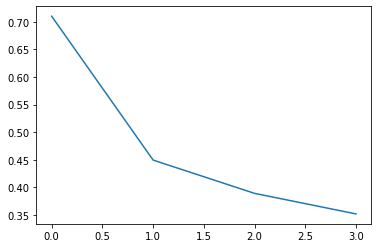

In [28]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(train_losses)

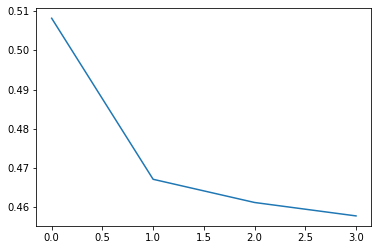

In [29]:
plt.figure()
plt.plot(val_losses)

After instantiating a trained model, we can then score the test data and compute its accuracy. We then print the classification report and plot a confusion matrix.

The trained model gives us good results on the test data, being able to correctly classify 80% or more on each of the 6 distinct categories.

In [30]:
batch_size = 32

test_data = TensorDataset(test_x, test_m)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

outputs = []
with torch.no_grad():
    model.eval()
    for k, (mb_x, mb_m) in enumerate(test_dataloader):
        mb_x = mb_x.to(device)
        mb_m = mb_m.to(device)
        output = model(mb_x, attention_mask=mb_m)
        outputs.append(output[0].to('cpu'))

outputs = torch.cat(outputs)

In [31]:
_, predicted_values = torch.max(outputs, 1)
predicted_values = predicted_values.numpy()
true_values = test_y.numpy()

In [32]:
test_accuracy = np.sum(predicted_values == true_values) / len(true_values)
print ("Test Accuracy:", test_accuracy)

Test Accuracy: 0.8497563043017589


In [33]:
from sklearn.metrics import classification_report

print(classification_report(true_values, predicted_values, target_names=[str(l) for l in label_values]))

                  precision    recall  f1-score   support

Banking Services       0.88      0.83      0.85       411
   Card Services       0.80      0.80      0.80       524
Credit Reporting       0.88      0.86      0.87      1665
 Debt Collection       0.82      0.84      0.83      1045
           Loans       0.76      0.81      0.78       486
        Mortgage       0.92      0.92      0.92       588

       micro avg       0.85      0.85      0.85      4719
       macro avg       0.84      0.84      0.84      4719
    weighted avg       0.85      0.85      0.85      4719



In [34]:
import itertools

# plot confusion matrix
# code borrowed from scikit-learn.org
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 343   29   12   11   10    6]
 [  26  420   41   25   11    1]
 [   7   41 1436  115   48   18]
 [   8   24   77  880   39   17]
 [   3   12   45   26  392    8]
 [   5    1   14   10   19  539]]
Normalized confusion matrix
[[0.83 0.07 0.03 0.03 0.02 0.01]
 [0.05 0.8  0.08 0.05 0.02 0.  ]
 [0.   0.02 0.86 0.07 0.03 0.01]
 [0.01 0.02 0.07 0.84 0.04 0.02]
 [0.01 0.02 0.09 0.05 0.81 0.02]
 [0.01 0.   0.02 0.02 0.03 0.92]]


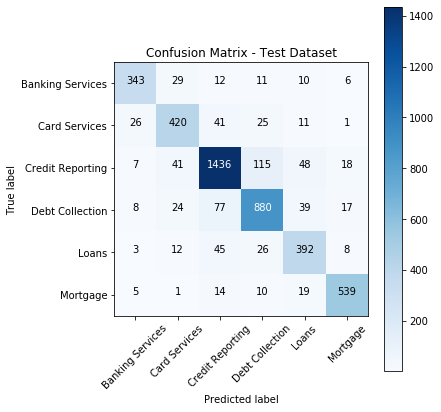

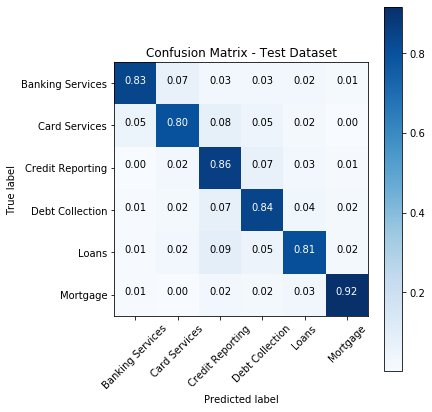

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

cm_test = confusion_matrix(true_values, predicted_values)

np.set_printoptions(precision=2)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset')
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset', normalize=True)